# LENS Multi Simulation Mean Plots

In [68]:
import os
import numpy as np

import scipy.stats as sp 
import scipy.stats as stats
import matplotlib as plt
import matplotlib.pyplot as mp
from matplotlib.ticker import PercentFormatter
from matplotlib import cm

import shapely.geometry as sgeom


import xarray as xr
import datetime as dt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

from pprint import pprint

from distributed import Client
#from ncar_jobqueue import NCARCluster

In [69]:
#cluster = NCARCluster()
#cluster.scale(10)
#client = Client(cluster)

client = Client()
client


/Users/rneale/miniconda3/envs/neale_myenv/lib/python3.7/site-packages/distributed/node.py:161: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 51962 instead
  f"Port {expected} is already in use.\n"


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:51962/status,
Dashboard: http://127.0.0.1:51962/status,Workers: 4
Total threads: 8,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:51963,Workers: 4
Dashboard: http://127.0.0.1:51962/status,Total threads: 8
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:51976,Total threads: 2
Dashboard: http://127.0.0.1:51979/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:51967,


<hr>
Set up datasets
<hr>

In [77]:
run_info =  {}

myhost = os.uname()[1]

################
#### LENS 1 ####
################
'''
    ### LENS1 ###
'''


#run_info['run_set'] = 'lens1' ;  nens_max = 40 ; rname_strong = [10, 21, 11,16,20] ; rname_weak = [7,4,22,29,35]
#run_info['run_set'] = 'lens1' ;  nens_max = 40 ; rname_strong = [10, 21, 11] ; rname_weak = [7,4,22]

# Dir if on CGD/thorodin

#run_info['run_freq'] = 'month_1' #Frequency to analyze


# Dir if on casper/cheyenne

#run_info['run_freq'] = 'monthly' #Frequency to analyze



## PD ##
#run_info['run_pref'] = 'b.e11.B20TRC5CNBDRD.f09_g16' ; rtype='historical'
#run_info['run_suff'] = '192001-200512' # File suffix
#run_info['run_yrs'] =  (1979,2005) #First/last years to grab



## RCP85 ##
#run_info['run_pref'] = 'b.e11.BRCP85C5CNBDRD.f09_g16' ; rtype = 'rcp85'
#run_info['run_suff'] = '208101-210012' # File suffix
#run_info['run_yrs'] =  (2081,2100) # First/last years to grab



'''
    ### LENS2 ###
'''




run_info['run_set'] = 'lens2' ; nens_max = 40 ; rname_strong = [38,11,22] ; rname_weak = [17,13,30]
#run_info['run_set'] = 'lens2' ; nens_max = 40 ; rname_strong = [11,22,24, 38,37,10] ; rname_weak = [17,13,19,30,26,32]

#run_info['run_set'] = 'lens2' ; nens_max = 40 ; rname_strong = [38] ; rname_weak = [30]

## PD ##
run_info['run_pref'] = 'b.e21.BHISTcmip6.f09_g17.LE2' ; rtype='historical'
run_info['run_suff'] = '192001-200512' # File suffixlens
run_info['run_yrs'] =  (1979,2005) #First/last years to grab



## RCP85 ##
#run_info['run_pref'] = 'b.e11.BRCP85C5CNBDRD.f09_g16' ; rtype = 'rcp85'
#run_info['run_suff'] = '208101-210012' # File suffix
#run_info['run_yrs'] =  (2081,2100) # First/last years to grab



'''
    ### CMIP6 ###
'''


#run_info['run_set'] = 'cmip6'
#run_info['run_freq'] = 'monthly' 


## PD ##
#lens_range = False
#run_info['run_pref'] = '' ; rtype='historical'
#run_info['run_yrs'] =  (1948,2005) # First/last years to grab
#run_info['run_suff'] = '185001-201412'
#run_info['run_ens'] = (1,2,3,4,5,6,7,8,10,11) # First and last ensemble member


## RCP85/SSP85 ##

#run_info['run_pref'] = '' ; rtype='ssp585'
#run_info['run_yrs'] =  (2081,2100) # First/last years to grab
#run_info['run_suff'] = '185001-201412'


'''
    ### Machine dependent dir. specs. ###
'''
print(myhost)
if myhost not in ['cheyenne','casper','cgdm_freesia']:
    run_info['run_root'] = '/project/mojave/cesm1/LENS/atm/'   # Root directory on CGD systems
    run_info['run_freq'] = 'month_1' #Frequency to analyze
    

if myhost in ['cheyenne','casper']: # ...on CISL machines
    run_info['run_root'] = '/glade/collections/cdg/data/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/' if run_info['run_set'] == 'lens1' else  '/glade/campaign/cgd/cesm/CESM2-LE/atm/proc/tseries/' # LENS root directory
    run_info['run_freq'] = 'monthly' #Frequency to analyze

if myhost in ['cgdm-freesia']: # ...on local
    run_info['run_root'] = '/Users/rneale/Documents/NCAR/data/LENS1/' if run_info['run_set'] == 'lens1' else '/Users/rneale/Documents/NCAR/data/LENS2/'
    run_info['run_freq'] = 'monthly' #Frequency to analyze  
    

    
'''
    ### Region, Variable, Obs. specs etc. ###
'''

lens_range = True


run_info['run_ens'] = (1,nens_max) # Only subset availabele for some reason.

run_info['plot_obs'] = True # Obs if future mostly.
run_info['obs_yrs'] = (1979,2005)

run_info['run_var'] = 'TS' ; vscale = 1.
#run_info['run_var'] = 'TMQ' ; vscale = 1.

run_info['run_period'] =  ('Dec','Jan','Feb') # Monthly to consider



    
# Regions (lats/latn/lonw/lone)
run_info['run_reg'] = np.array([-15,15.,50.,95.]) ; ave_dim= 'lon'; pname = 'lon_ave' # Lat/on  ranges 
#run_info['run_reg'] = np.array([-15,15.,150.,200.]) ; ave_dim= 'lon'; pname = 'lon_ave' # Lat/on  ranges 
#run_info['run_reg'] = np.array([-10.,0.,150.,200.]) ; ave_dim = 'lat'; pname = 'lat_ave' # Lat/on  ranges 
#run_info['run_reg'] = np.array([-5.,5.,50.,95.]) ; ave_dim = 'lat'; pname = 'lat_ave' # Lat/on  ranges 


cgdm-freesia


50.0
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]
** Loop index,nens, name,fname,pc_mean =  0 40 1 1231.001 24.876213
--/Users/rneale/Documents/NCAR/data/LENS2/monthly/TS/b.e21.BHISTcmip6.f09_g17.LE2-1231.001.cam.h0.TS*.nc
** Loop index,nens, name,fname,pc_mean =  1 40 2 1231.002 24.912266
--/Users/rneale/Documents/NCAR/data/LENS2/monthly/TS/b.e21.BHISTcmip6.f09_g17.LE2-1231.002.cam.h0.TS*.nc
** Loop index,nens, name,fname,pc_mean =  2 40 3 1231.003 24.801561
--/Users/rneale/Documents/NCAR/data/LENS2/monthly/TS/b.e21.BHISTcmip6.f09_g17.LE2-1231.003.cam.h0.TS*.nc
** Loop index,nens, name,fname,pc_mean =  3 40 4 1231.004 24.998219
--/Users/rneale/Documents/NCAR/data/LENS2/monthly/TS/b.e21.BHISTcmip6.f09_g17.LE2-1231.004.cam.h0.TS*.nc
** Loop index,nens, name,fname,pc_mean =  4 40 5 1231.005 25.250355
--/Users/rneale/Documents/NCAR/data/LENS2/monthly/TS/b.e21.BHISTcmip6.f09_g17.LE2-1231.005.cam.h0.TS*.nc
** Loop

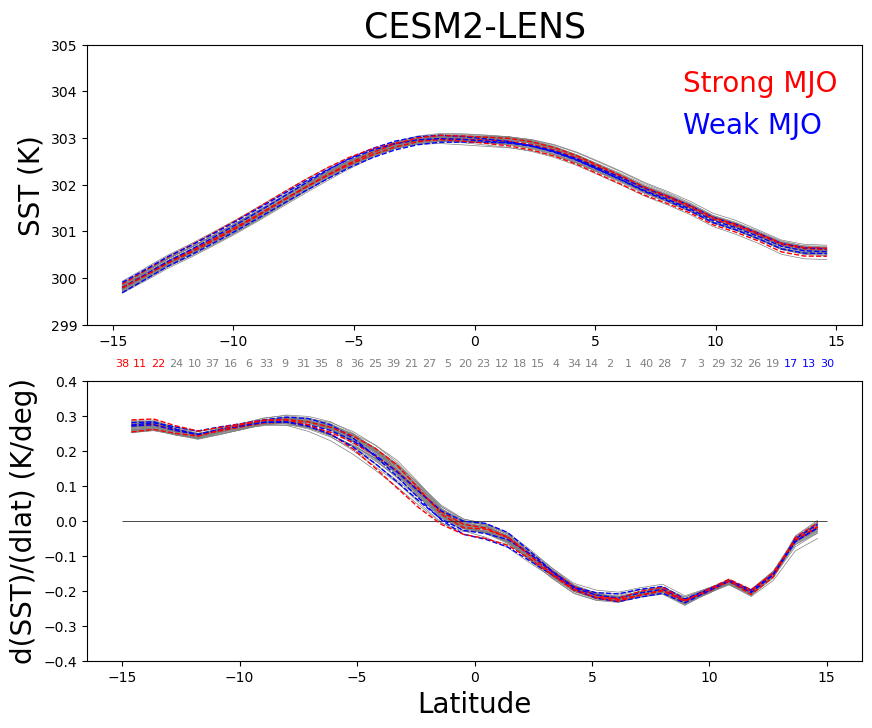

In [78]:
##################################

run_root   = run_info['run_root']
run_set    = run_info['run_set'] 
run_freq   = run_info['run_freq']
run_obs    = run_info['plot_obs']
obs_yrs    = run_info['obs_yrs']
run_pref   = run_info['run_pref']
run_var    = run_info['run_var']
run_ens    = run_info['run_ens']
run_suff   = run_info['run_suff']
run_yrs    = run_info['run_yrs']
run_period = run_info['run_period']
run_reg    = run_info['run_reg']

print(run_reg[2])

# OBS #
obs_root = '/glade/work/rneale/data/NOAA_CPC_USA/'

#nens = run_ens[1]-run_ens[0]+1
nmonths = len(run_period)

#
if run_var == 'TS':
    y_min,y_max,ydl_min,ydl_max = 299,305,-0.4,0.4
    p_title = 'SST (K)'
if run_var == 'TMQ':
    y_min,y_max,ydl_min,ydl_max = 20,60,-3,3
    p_title = 'Precip. Water. (mm)'
    
    
    
# Regions in string
reg_a_out = '%d-%dW_%.1f-%dN' % (360-run_reg[2],360-run_reg[3],run_reg[0],run_reg[1])
#str(run_yrs[0]):str(run_yrs[1]),run_reg[0]:run_reg[1],run_reg[2]:run_reg[3]] 
lat_reg =  []
lon_reg =  []
time_reg = [str]


# Ensemble number/name array #
if lens_range: 
    run_nums = np.arange(run_ens[0],run_ens[1]+1,1) # Wierdly needs run_ens+1
    if run_set == 'lens1':  run_nums[run_nums>35] = run_nums[run_nums>35]+66  ## Need to chnage 36-40 ens members to 101-105.
    print(run_nums)
        
else:
    run_nums = np.array(run_ens)

nens = len(run_nums)

var_tav_ens = False
nyrs = run_yrs[1]-run_yrs[0]+1 # Number of years


var_tav_ts = np.zeros((nmonths,len(run_nums),nyrs))

#if run_set=='lens1'

nens_lens2 = 10
yr0_lens2 = np.array(['1231','1251','1281','1301'])
nyr0_lens2 = yr0_lens2.size
yr0_lens2_arr = np.sort(np.tile(yr0_lens2,nens_lens2)) #Make copies of yr0 for each ensemble member
ens_lens2_arr = np.tile(np.arange(1,nens_lens2+1),nyr0_lens2) # Reverse for each year



#yr0_lens2_arr = np.array([item + '-' for item in yr0_lens2_arr]).astype(str) #Add a '-'
#print(yr0_lens2_arr.dtype)

#print(yr0_lens2_arr)
#print(ens_lens2_arr.dtype)

## Cannot figure out why they ar enow different data types
#lens2_yr_ens = np.add(yr0_lens2_arr.astype(str),ens_lens2_arr.astype(str))


#var_tav_ens = None
fig, ax = mp.subplots(2,1,figsize=(10, 8))






#################
# Grab pc1pc2 PCs
#################

dir_pcs = '/Users/rneale/Documents/NCAR/pc1pc2_comp/data/'


if run_set == 'lens1':
    pc1pc2_file = '20th_ystart.1979-yend.2005-nens.40.nc'
if run_set == 'lens2':
    pc1pc2_file = '20th_l2_ystart.1979-yend.2005-nens.40.nc'
    
pc1pc2 = xr.open_dataset(dir_pcs+pc1pc2_file)
pc1pc2 = pc1pc2.sel(ensemble=slice(run_ens[0],run_ens[1]))
pc_mean = np.sqrt(pc1pc2.PC1_var**2+pc1pc2.PC2_var**2)

pc_range = np.max(pc_mean)-np.max(pc_mean)
norm_col = plt.colors.Normalize(vmin=np.min(pc_mean), vmax=np.max(pc_mean))










### ### ### ### ### 
###  Loop Cases ###
### ### ### ### ### 

for ir,rname in enumerate(run_nums):
   
  

    if run_set=='lens1':
        
        run_suff = '185001-200512' if rname == 1 and run_var == 'TMQ' else run_info['run_suff']
        
        rnamef = '{:03}'.format(rname)  # Format for ens# in LENS
        run_file = run_root+run_freq+'/'+run_var+'/'+run_pref+'.'+str(rnamef)+'.cam.h0.'+run_var+'.'+run_suff+'.nc'
        
    if run_set=='lens2':
       
        rnamef = yr0_lens2_arr[ir]+'.'+'{:03}'.format(ens_lens2_arr[ir]) # Format for ens# in LENS
        run_file = run_root+run_freq+'/'+run_var+'/'+run_pref+'-'+str(rnamef)+'.cam.h0.'+run_var+'*.nc'

    if run_set=='cmip6':
        rname = '{:01}'.format(rnamef) # Format for ens# in LENS
        if rtype=='historical':
            run_file0 = run_root+'CMIP/NCAR/CESM2/historical/'
#  run_file = run_file0+'r'+rname+'i1p1f1/Amon/'+run_var+'/gn/latest/'+run_var+'_Amon_CESM2_historical_r'+rname+'i1p1f1_gn_'+run_suff+'.nc'
            run_file = run_file0+'r'+rnamef+'i1p1f1/Amon/'+run_var+'/gn/latest/'+run_var+'_Amon_CESM2_historical_r'+rnamef+'i1p1f1_gn_*.nc'
        if rtype=='ssp585':
            print('hi')
            run_file0 = run_root+'ScenarioMIP/NCAR/CESM2/ssp585/'
            run_file = run_file0+'r'+rnamef+'i1p1f1/Amon/'+run_var+'/gn/latest/'+run_var+'_Amon_CESM2_ssp585_r'+rnamef+'i1p1f1_gn_*.nc'
            print('')
            
  
    
    
# Regional/temporal data selection

    if run_var=='PRECT':
        run_file_c = run_root+run_freq+'/PRECC/'+run_pref+'.'+str(rnamef)+'.cam.h0.PRECC.'+run_suff+'.nc'
        run_obj_c = xr.open_dataset(run_file_c,engine='netcdf4',parallel=True)
    
        run_file_l = run_root+run_freq+'/PRECL/'+run_pref+'.'+str(rnamef)+'.cam.h0.PRECL.'+run_suff+'.nc'
        run_obj_l = xr.open_dataset(run_file_l,engine='netcdf4',parallel=True)
        
        var_c = run_obj_c['PRECC'].loc[str(run_yrs[0]):str(run_yrs[1]),run_reg[0]:run_reg[1],run_reg[2]:run_reg[3]] 
        var_l = run_obj_l['PRECL'].loc[str(run_yrs[0]):str(run_yrs[1]),run_reg[0]:run_reg[1],run_reg[2]:run_reg[3]] 
        var   = var_c+var_l
        
    else :
        
        run_obj = xr.open_mfdataset(run_file,engine='netcdf4',parallel=True)
        var = run_obj[run_var].loc[str(run_yrs[0]):str(run_yrs[1]),run_reg[0]:run_reg[1],run_reg[2]:run_reg[3]] 
        
    var = var*vscale
    
    
    print('** Loop index,nens, name,fname,pc_mean = ', ir,nens,rname,rnamef,pc_mean[ir].values)
    print('--'+run_file)

    
    
    
# Latitude (weighted) and longitude averaging
    gw_lat = np.cos(np.deg2rad(var.lat.values))  # Latitude weights

#    var_av = (var * gw_lat[None, :, None]).sum(dim='lat') / np.sum(gw_lat)

    var_av = var.mean(ave_dim)
    
    if ave_dim=='lat' :
        var_av_dim = var_av.lon ; xalabel = "Longitude"
        if run_var == 'TS': yalabel = 'd(SST)/(dlon) (K/deg)'
        if run_var == 'TMQ': yalabel = 'd(PW)/(dlon) (mm/deg)'
        x0,x1 = run_reg[2],run_reg[3]
    else :
        var_av_dim = var_av.lat ; xalabel = "Latitude"
        if run_var == 'TS': yalabel = 'd(SST)/(dlat) (K/deg)'
        if run_var == 'TMQ': yalabel = 'd(PW)/(dlat) (mm/deg)'
        x0,x1 = run_reg[0],run_reg[1]
        
    
# Time average (month or season)
    if ir==0:
        time = var.time # Read time
        months = time.dt.month # Array of months number
        mon_name = time.dt.strftime('%b') # Array of month names
        ptime = time.dt.year+(time.time.dt.month-1)/12 # Fraction of year (jan=0). x-axis on tseries plots\    
        pyear = time.dt.year # Just grab year array for tseries plots
  
# Pick out averaging months 

    ind_mons = np.where(np.in1d(mon_name, run_period))[0] #Picks out reqwested months available in full data.
    var_av = var_av[ind_mons,:].mean('time')
   


###########################
## Lon or Lat Plot Averages
###########################


    
    line_col,lw,lstyle,zord = ('gray',0.5,'-',0)
#    line_col,lw,lstyle,zord = (cm.coolwarm(norm_col(pc_mean[ir])) ,0.5,'-',0)

    
    if run_set=='lens1': model_name = 'CESM1-LENS'        
    if run_set=='lens2':model_name = 'CESM2-LENS'
    
    if rname in rname_weak: line_col,lw,lstyle,zord = ('blue',1,'--',10) ; print("   ---- Weakest MJO ----")         
    if rname in rname_strong:line_col,lw,lstyle,zord = ('red',1,'--',10)  ; print("   ---- Strongest MJO ----")            

    var_av_grad = np.gradient(var_av) 

 
    ax[0].plot(var_av_dim,var_av,color=line_col,lw=lw,linestyle=lstyle,zorder=zord)
    ax[1].plot(var_av_dim,var_av_grad,color=line_col,lw=lw,linestyle=lstyle,zorder=zord)

## Add text for position of iens
    iens_posn = np.argwhere(np.sort(pc_mean)[::-1] == pc_mean[ir].values)
    
#    if ir==0:
#        y0,y1 = ax[1].get_ylim()    
       
    ax[1].text(x0+iens_posn*(x1-x0)/(nens-1), ydl_max+0.05*(ydl_max-ydl_min), ir+1,fontsize = 8,color=line_col,horizontalalignment='center')

    
ax[0].set_ylim([y_min,y_max])
ax[1].set_ylim([ydl_min,ydl_max])
    
    
ax[0].set_title(model_name,fontsize = 25)
ax[0].set_ylabel(p_title,fontsize=20) 
ax[0].legend(labels=['Strong MJO','Weak MJO'],labelcolor =['red','blue'],handlelength=0., frameon=False,fontsize='20')
#    ax[0].set_xlabel(xalabel)
#    ax[0].vlines(0., min(var_av),max(var_av), linestyle="dotted",lw=1)
    
#    ax[1].set_title(model_name)
ax[1].set_ylabel(yalabel,fontsize=20) 
ax[1].set_xlabel(xalabel,fontsize=20) 
    
    
if ave_dim == 'lon':
    ax[1].hlines(0.,run_reg[0],run_reg[1],linestyle="solid",lw=0.5,color='k')
else:
    ax[1].hlines(0.,run_reg[2],run_reg[3],linestyle="solid",lw=0.5,color='k')

    
mp.savefig(run_var+'_MJO_strong-week_'+model_name+'_'+reg_a_out+'_'+pname+'.png', dpi=120)    
   

In [ ]:
 

#############################
###### Observations #########
#############################

#if run_obs :

#    obs_file = obs_root+'precip.V1.0.mon.mean.nc'
#    obs_obj = xr.open_dataset(obs_file,engine='netcdf4')
#    ovar = obs_obj['precip'].loc[str(obs_yrs[0]):str(obs_yrs[1]),run_reg[0]:run_reg[1],run_reg[2]:run_reg[3]] 

    
    
# Latitude (weighted) and longitude averaging
#    ogw_lat = np.cos(np.deg2rad(ovar.lat.values))  # Latitude weights
#    ovar_av = (ovar * ogw_lat[None, :, None]).sum(dim='lat') / np.sum(ogw_lat)
#    ovar_av = ovar_av.mean('lon')
    
    
# Obs. time
#    time = ovar.time # Read time
#    months = time.dt.month # Array of months number

#    mon_name = time.dt.strftime('%B') # Array of month names
#    ptime = time.dt.year+(time.time.dt.month-1)/12 # Fraction of year (jan=0). x-axis on tseries plots
#    pyear0 = time.dt.year # Just brab year array for tseries plots

#    obs_tav_tup = () # Reset for this run
    
    
# Accumulate #
#    for im in range(len(run_period)):
#        im4ave = np.where(mon_name==run_period[im]) # Indices for this month

#        obs_tav = ovar_av[im4ave] # Values each year for this month.
#        obs_tav_now = obs_tav                    
#        obs_tav_tup = obs_tav_tup+(obs_tav_now,) # Add to tuple for plotting






########################################       
## Plot map with averaging location   ##
########################################       

figm = mp.figure()

axm = figm.add_subplot(projection=ccrs.PlateCarree())

r1 = run_reg[2] if run_reg[3] <=180. else run_reg[2]-360.
r2 = run_reg[0] 
r3 = run_reg[3] if run_reg[3] <=180. else run_reg[3]-360.
r4 = run_reg[1] 


print('-- Region -> ',r1,r2,r3,r4)
print('')

extent_box = sgeom.box(r1,r2,r3,r4)

shapename = 'admin_1_states_provinces_lakes_shp'
#states_shp = shpreader.natural_earth(resolution='110m',category='cultural', name=shapename)
#axm.add_geometries(shpreader.Reader(states_shp).geometries(),ccrs.PlateCarree(),edgecolor='black')

#axm.set_extent([-180,-270, -40,40], crs=ccrs.PlateCarree())
axm.add_geometries([extent_box], ccrs.PlateCarree(), facecolor='none',
                          edgecolor='red', linewidth=2)

axm.coastlines()
#axm.add_feature(cfeature.LAND)
#axm.add_feature(cfeature.COASTLINE)

    
    
#CDF too!


    
  

<hr>
Plotting
<hr>